# XGBoost
In this Jupyter Notebook a the XGBoost model will be implemented. Data cleaning from the previous notebook will be used and then it is splitted into trainin-validation-test sets for implementing the XGBoost model. The following steps are developed in this work:

1. Data preparation.
2. Model Development <br>
    2.1 XGBoost <br>
    2.2 XGBoost tuning <br>
    &ensp; 2.2.1 Tuning `eta`<br>
    &ensp; 2.2.2 Tuning `max_depth`<br>
    &ensp; 2.2.3 Tuning `min_child_weight`<br>
    2.3. Best XGBoost Model

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import KFold

import xgboost as xgb

## 1. Data preparation

In [3]:
df = pd.read_csv('../datasets/heart_disease/heart_2020_cleaned.csv')
df.columns = df.columns.str.lower()

numerical = list(df.dtypes[df.dtypes == 'float'].index.values)
categorical = list(df.dtypes[df.dtypes == 'object'].index.values)
categorical.remove('heartdisease')

for c in categorical:
    df[c] = df[c].str.lower()

df['heartdisease'] = df['heartdisease'].str.lower()


df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = (df_train['heartdisease']=='yes').astype('int').values
y_val = (df_val['heartdisease']=='yes').astype('int').values
y_test = (df_test['heartdisease']=='yes').astype('int').values

df_train = df_train.drop(columns='heartdisease')
df_val = df_val.drop(columns='heartdisease')
df_test = df_test.drop(columns='heartdisease')

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

## 2. Model Development

### 2.1 XGBoost

In [5]:
feature_names = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(data=X_val, label=y_val, feature_names=feature_names)

In [6]:
# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':0.3,
             'max_depth':6,
             'min_child_weight':1,
              
             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',
              
             'seed':1,
             'verbosity':1}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [7]:
y_pred = model.predict(dval)

In [8]:
roc_auc_score(y_val, y_pred)

0.835345722522628

### 2.2 XGBoost Tunning

In [9]:
%%capture output

# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':0.3,
             'max_depth':6,
             'min_child_weight':1,
              
             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',
              
             'seed':1,
             'verbosity':1}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=watchlist, verbose_eval=1)

In [10]:
output.show()

[0]	train-auc:0.77534	val-auc:0.77463
[1]	train-auc:0.78479	val-auc:0.78436
[2]	train-auc:0.78880	val-auc:0.78835
[3]	train-auc:0.80651	val-auc:0.80636
[4]	train-auc:0.81634	val-auc:0.81644
[5]	train-auc:0.82172	val-auc:0.81985
[6]	train-auc:0.82638	val-auc:0.82417
[7]	train-auc:0.83089	val-auc:0.82843
[8]	train-auc:0.83289	val-auc:0.83015
[9]	train-auc:0.83406	val-auc:0.83139
[10]	train-auc:0.83815	val-auc:0.83491
[11]	train-auc:0.84071	val-auc:0.83730
[12]	train-auc:0.84205	val-auc:0.83866
[13]	train-auc:0.84320	val-auc:0.83941
[14]	train-auc:0.84428	val-auc:0.83979
[15]	train-auc:0.84510	val-auc:0.83996
[16]	train-auc:0.84603	val-auc:0.84042
[17]	train-auc:0.84695	val-auc:0.84084
[18]	train-auc:0.84736	val-auc:0.84095
[19]	train-auc:0.84812	val-auc:0.84134
[20]	train-auc:0.84897	val-auc:0.84156
[21]	train-auc:0.84942	val-auc:0.84174
[22]	train-auc:0.85008	val-auc:0.84179
[23]	train-auc:0.85060	val-auc:0.84179
[24]	train-auc:0.85126	val-auc:0.84203
[25]	train-auc:0.85206	val-auc:0.84

In [11]:
def parse_xgb_output(output):
    scores = []
    lines = output.stdout.split('\n')[:-1]
    for line in lines:
        n = int(line.split('\t')[0].strip('[]'))
        train_auc = float(line.split('\t')[1].split(':')[1])
        val_auc = float(line.split('\t')[2].split(':')[1])
        #scores.append((n, train_auc, val_auc))
        scores.append((n, train_auc, val_auc))
        
    return scores

In [12]:
columns = ['n_estimators', 'train_auc', 'val_auc']
df_parsed_xbg = pd.DataFrame(parse_xgb_output(output), columns=columns)

In [13]:
df_parsed_xbg

,n_estimators,train_auc,val_auc
0,0,0.77534,0.77463
1,1,0.78479,0.78436
2,2,0.78880,0.78835
3,3,0.80651,0.80636
4,4,0.81634,0.81644
...,...,...,...
995,995,0.94937,0.81177
996,996,0.94939,0.81180
997,997,0.94946,0.81185
998,998,0.94949,0.81181


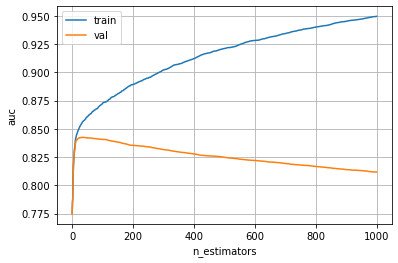

In [14]:
plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='val')
plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.legend()
plt.show()

#### 2.2.1 Tuning `eta`

In [15]:
etas = [1, 0.1, 0.01, 0.001 ]

In [16]:
models_dict = {}

**Note:** You must run manually each cell changing the value of `i` to select different `etas`.

In [27]:
%%capture output

i = 3

# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':etas[i],
             'max_depth':6,
             'min_child_weight':1,

             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',

             'seed':1,
             'verbosity':1}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=watchlist, verbose_eval=1)

In [28]:
models_dict['eta_%s'%etas[i]] = (model, parse_xgb_output(output))

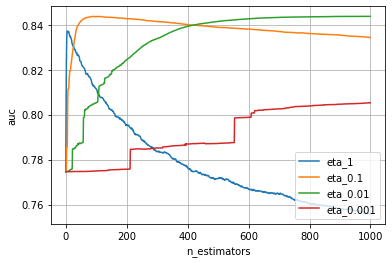

In [29]:
columns = ['n_estimators', 'train_auc', 'val_auc']

for key in models_dict.keys():
    df_parsed_xbg = pd.DataFrame(models_dict[key][1], columns=columns)
    #plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
    plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='%s'%key)

plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.legend(loc='lower right')
plt.show()

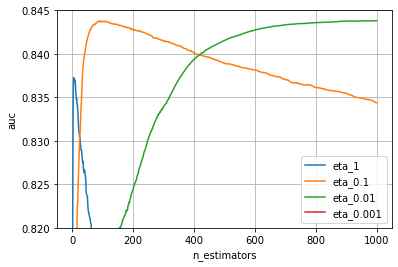

In [30]:
columns = ['n_estimators', 'train_auc', 'val_auc']

for key in models_dict.keys():
    df_parsed_xbg = pd.DataFrame(models_dict[key][1], columns=columns)
    #plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
    plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='%s'%key)

plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.ylim(0.82, 0.845)
plt.legend()
plt.show()

In [31]:
best_eta = 0.01

#### 2.2.2 Tuning `max_depth`

In [32]:
max_depths = [1, 2, 3, 5, 6, 10]

In [33]:
models_dict = {}

In [51]:
%%capture output

i = 5

# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':best_eta,
             'max_depth':max_depths[i],
             'min_child_weight':1,

             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',

             'seed':1,
             'verbosity':1}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=watchlist, verbose_eval=1)

In [52]:
models_dict['max_depth%s'%max_depths[i]] = (model, parse_xgb_output(output))

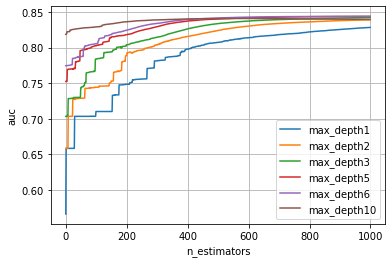

In [53]:
columns = ['n_estimators', 'train_auc', 'val_auc']

for key in models_dict.keys():
    df_parsed_xbg = pd.DataFrame(models_dict[key][1], columns=columns)
    #plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
    plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='%s'%key)

plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.legend(loc='lower right')
plt.show()

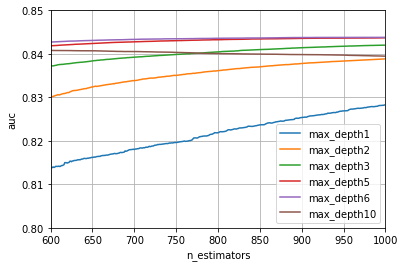

In [54]:
columns = ['n_estimators', 'train_auc', 'val_auc']

for key in models_dict.keys():
    df_parsed_xbg = pd.DataFrame(models_dict[key][1], columns=columns)
    #plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
    plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='%s'%key)

plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.legend(loc='lower right')
plt.xlim(600,1000)
plt.ylim(0.800,0.850)
plt.show()

In [55]:
best_max_depth = 6

#### 2.2.3 Tuning `min_child_weight`

In [56]:
min_child_weights = [1, 100, 1000, 10000]

In [57]:
models_dict = {}

In [67]:
%%capture output

i = 3

# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':best_eta,
             'max_depth':best_max_depth,
             'min_child_weight':min_child_weights[i],

             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',

             'seed':1,
             'verbosity':1}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=watchlist, verbose_eval=1)

In [68]:
models_dict['min_child_weights%s'%min_child_weights[i]] = (model, parse_xgb_output(output))

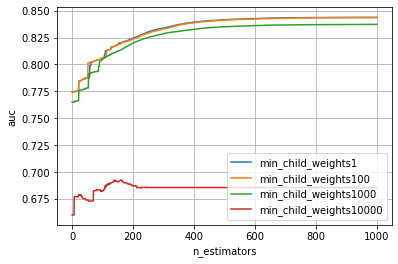

In [69]:
columns = ['n_estimators', 'train_auc', 'val_auc']

for key in models_dict.keys():
    df_parsed_xbg = pd.DataFrame(models_dict[key][1], columns=columns)
    #plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.train_auc, label='train')
    plt.plot(df_parsed_xbg.n_estimators, df_parsed_xbg.val_auc, label='%s'%key)

plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.grid('on')
plt.legend(loc='lower right')
plt.show()

In [70]:
best_min_child_weights = 1

### 2.3. Best XGBoost Model

In [71]:
best_eta = 0.01
best_max_depth = 6
best_min_child_weights = 1

In [72]:
# More information regarding xgb_params can be found here
# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {'eta':best_eta,
             'max_depth':best_max_depth,
             'min_child_weight':best_min_child_weights,
              
             'objective':'binary:logistic',
             'nthread':8,
              'eval_metric':'auc',
              
             'seed':1,
             'verbosity':1}

model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

In [73]:
y_pred = model.predict(dval)

In [74]:
roc_auc_score(y_val, y_pred)

0.8438294841549496